In [1]:
# Run in Jupyter cell
!pip install torch torchvision torchaudio pandas numpy opencv-python matplotlib scikit-learn kaggle

INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 5.6 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.5 MB 2.6 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 3.6 MB/s eta 0:00:00


In [13]:
import os
import zipfile
# from kaggle.api.kaggle_api_extended import KaggleApi


with zipfile.ZipFile('lisa-traffic-light-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lisa_dataset')

print("Dataset downloaded and extracted to 'lisa_dataset'")


Dataset downloaded and extracted to 'lisa_dataset'


In [3]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# ---- Configuration ----
CLASS_MAP = {
    'stop': 'red', 'stopLeft': 'red',
    'warning': 'yellow', 'warningLeft': 'yellow',
    'go': 'green', 'goLeft': 'green'
}
IMG_SIZE = (64, 64)
OUTPUT_DIR = "processed_data"
os.makedirs(os.path.join(OUTPUT_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "test"), exist_ok=True)

# ---- Load Annotations with Semicolon Parsing ----
def process_dataset(annotation_path, img_folder):
    df = pd.read_csv(annotation_path, sep=';')
    df.columns = df.columns.str.strip()  # Clean column names

    print(f"\n📄 Loaded: {annotation_path}")
    print("🧾 Available Columns:", df.columns.tolist())

    if 'Annotation tag' not in df.columns:
        raise KeyError("❌ Column 'Annotation tag' not found.")

    data = []

    for _, row in df.iterrows():
        if row['Annotation tag'] not in CLASS_MAP:
            continue

        # Build clean image path
        raw_filename = row['Filename'].replace('/', os.sep).replace('\\', os.sep)
        img_path = os.path.normpath(os.path.join("lisa_dataset", img_folder, raw_filename))

        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Image not found or unreadable: {img_path}")
            continue

        try:
            x1 = int(row['Upper left corner X'])
            y1 = int(row['Upper left corner Y'])
            x2 = int(row['Lower right corner X'])
            y2 = int(row['Lower right corner Y'])
            cropped = img[y1:y2, x1:x2]

            if cropped.size == 0:
                print(f"⚠️ Empty crop: {img_path}")
                continue

            # Resize and normalize
            resized = cv2.resize(cropped, IMG_SIZE) / 255.0

            class_name = CLASS_MAP[row['Annotation tag']]
            data.append((resized, class_name))

        except Exception as e:
            print(f"❌ Error processing image {img_path}: {e}")
            continue

    return data

# ---- Dataset Parts ----
parts = [
    ("lisa_dataset/Annotations/Annotations/dayTrain/dayClip1/frameAnnotationsBOX.csv", "dayTrain/dayClip1"),
    ("lisa_dataset/Annotations/Annotations/dayTrain/dayClip2/frameAnnotationsBOX.csv", "dayTrain/dayClip2"),
    ("lisa_dataset/Annotations/Annotations/daySequence1/frameAnnotationsBOX.csv", "daySequence/daySequence1"),
]

# ---- Process All Data ----
all_data = []
for csv_path, img_path in parts:
    all_data.extend(process_dataset(csv_path, img_path))

if not all_data:
    raise ValueError("❌ No data found. Make sure image paths and annotation mappings are valid.")

# ---- Split Data ----
images = [item[0] for item in all_data]
labels = [item[1] for item in all_data]

X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# ---- Save Processed Images ----
def save_data(images, labels, dataset_type):
    class_counts = {c: 0 for c in CLASS_MAP.values()}
    for img, label in zip(images, labels):
        class_dir = os.path.join(OUTPUT_DIR, dataset_type, label)
        os.makedirs(class_dir, exist_ok=True)
        filename = f"{label}_{class_counts[label]}.jpg"
        cv2.imwrite(os.path.join(class_dir, filename), (img * 255).astype(np.uint8))
        class_counts[label] += 1

save_data(X_train, y_train, "train")
save_data(X_test, y_test, "test")

print("\n✅ Dataset processed and saved successfully!")



📄 Loaded: lisa_dataset/Annotations/Annotations/dayTrain/dayClip1/frameAnnotationsBOX.csv
🧾 Available Columns: ['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y', 'Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number']

📄 Loaded: lisa_dataset/Annotations/Annotations/dayTrain/dayClip2/frameAnnotationsBOX.csv
🧾 Available Columns: ['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y', 'Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number']

📄 Loaded: lisa_dataset/Annotations/Annotations/daySequence1/frameAnnotationsBOX.csv
🧾 Available Columns: ['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y', 'Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number']

✅ Dataset processed and saved successfully!


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# ---- Custom Dataset Class ----
class TrafficLightDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['red', 'yellow', 'green']
        self.file_paths = []
        
        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            for file in os.listdir(label_dir):
                self.file_paths.append((os.path.join(label_dir, file), self.classes.index(label)))
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path, label = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label)

# ---- Data Augmentation ----
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# ---- Create DataLoaders ----
train_dataset = TrafficLightDataset(
    f"{OUTPUT_DIR}/train", 
    transform=train_transform
)
test_dataset = TrafficLightDataset(
    f"{OUTPUT_DIR}/test", 
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False
)

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- CNN Model ----
class TrafficLightCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),  # Adjust based on IMG_SIZE
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# ---- Training Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficLightCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

# ---- Training Loop ----
num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {accuracy:.2f}%")
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best.pt")
        print(f"Saved new best model with accuracy: {accuracy:.2f}%")
    
    scheduler.step(running_loss)  # Adjust learning rate

Epoch 1/20 | Loss: 0.0419 | Accuracy: 99.97%
Saved new best model with accuracy: 99.97%
Epoch 2/20 | Loss: 0.0154 | Accuracy: 100.00%
Saved new best model with accuracy: 100.00%
Epoch 3/20 | Loss: 0.0024 | Accuracy: 99.97%
Epoch 4/20 | Loss: 0.0042 | Accuracy: 99.70%
Epoch 5/20 | Loss: 0.0118 | Accuracy: 99.81%
Epoch 6/20 | Loss: 0.0133 | Accuracy: 99.92%
Epoch 7/20 | Loss: 0.0187 | Accuracy: 99.92%
Epoch 8/20 | Loss: 0.0021 | Accuracy: 99.97%
Epoch 9/20 | Loss: 0.0020 | Accuracy: 99.94%
Epoch 10/20 | Loss: 0.0019 | Accuracy: 99.94%
Epoch 11/20 | Loss: 0.0022 | Accuracy: 99.94%
Epoch 12/20 | Loss: 0.0013 | Accuracy: 99.94%
Epoch 13/20 | Loss: 0.0012 | Accuracy: 99.94%
Epoch 14/20 | Loss: 0.0014 | Accuracy: 99.94%
Epoch 15/20 | Loss: 0.0030 | Accuracy: 99.94%
Epoch 16/20 | Loss: 0.0007 | Accuracy: 99.94%
Epoch 17/20 | Loss: 0.0007 | Accuracy: 99.94%
Epoch 18/20 | Loss: 0.0010 | Accuracy: 99.94%
Epoch 19/20 | Loss: 0.0018 | Accuracy: 99.94%
Epoch 20/20 | Loss: 0.0014 | Accuracy: 99.94%


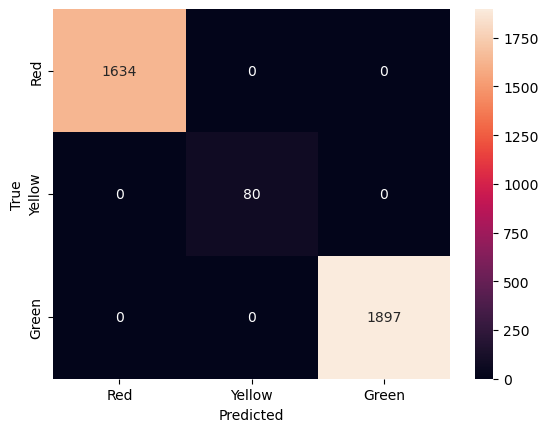

Prediction: red


In [13]:
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best.pt"))
model.eval()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Red','Yellow','Green'], 
            yticklabels=['Red','Yellow','Green'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Test on custom image
def predict_traffic_light(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
    
    class_names = ['red', 'yellow', 'green']
    return class_names[pred.item()]

# Example usage
print("Prediction:", predict_traffic_light("td1.png"))